# Regression

Build a regression model that uses historical data for a certain city (London test case) and takes in prediction variables for the weather the next 3 days.

It provides a color coded response based on PM 10 or PM 2.5.





## Data needed




Response variables: Pm 2.5 or pm 10 (mean,max,min)

Predictor variables: Weather data, what month, 

We use data from pollution api (Response variable) and weather api (predict variables)




# To do

Get data on humidity


In [27]:
# Packages we need for the project
# Probably we don't need all of this
import sys
from pandas.core.frame import DataFrame
import requests
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import openaq
import warnings
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression



# Choose the city
city = 'London'


# You need the csv.files for the city
Measurments = pd.read_csv(f'Data_measurements/{city}.csv')

Weather = pd.read_csv(f'Data_weather/{city}.csv')

In [2]:
# Joining both dataframes
final_df = pd.merge(Measurments, Weather, on= 'Date')

# Get column names
final_df.columns

Index(['ID', 'Date', 'pm10_mean', 'pm25_mean', 'pm10_max', 'pm25_max',
       'pm10_min', 'pm25_min', 'Unnamed: 0', 'tavg', 'prcp', 'wdir', 'wspd',
       'wpgt', 'pres'],
      dtype='object')

In [3]:
### Take care of NA values###

#Find lines with NA values

# Have 4 rows for London
final_df[final_df.isnull().any(axis=1)]

# Drop the NA lines
final_df = final_df.dropna()

In [4]:
# Create a month column in our dataframe
final_df['month'] = pd.DatetimeIndex(final_df['Date']).month
final_df['day'] = pd.DatetimeIndex(final_df['Date']).weekday


# Create the months as a string
# Used for plots later
def month_to_string(x):
    if x == 1:
        return 'January'
    if x == 2:
        return 'February'
    if x == 3:
        return 'March'
    if x == 4:
        return 'April'
    if x == 5:
        return 'Mai'
    if x == 6:
        return 'June'
    if x == 7:
        return 'July'
    if x == 8:
        return 'August'
    if x == 9:
        return 'September'
    if x == 10:
        return 'October'
    if x == 11:
        return 'November'
    return 'December'

final_df['month_string'] = final_df['month'].apply(month_to_string)

# Create a column to show if the day is on a weekend or not
def is_weekend (row):
    if row['day'] > 4:
        return 1
    return 0

final_df['is_weekend'] = final_df.apply (lambda row: is_weekend(row), axis=1)


# Create a log variable 
# Used later for regression
final_df['log_pm10_mean'] = np.log(final_df['pm10_mean'])

# Plotting 

## Response variables: PM2.5 and PM10

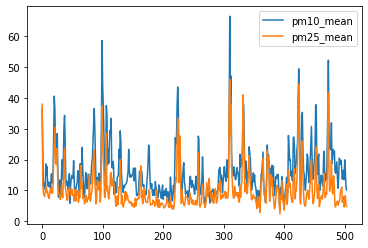

In [5]:
#final_df = final_df.set_index('Date')
final_df.plot(y=['pm10_mean','pm25_mean'])
plt.show()

In [6]:
final_df.plot(y=['pm10_max','pm25_max'])
plt.show()

## Day of the week, month and weekend vs Air quality

In [7]:
ax = sns.lineplot(x="Date", y="pm10_mean", data=final_df)
plt.show()

In [8]:
final_df.dtypes

ID                 int64
Date              object
pm10_mean        float64
pm25_mean        float64
pm10_max         float64
pm25_max         float64
pm10_min         float64
pm25_min         float64
Unnamed: 0         int64
tavg             float64
prcp             float64
wdir             float64
wspd             float64
wpgt             float64
pres             float64
month              int64
day                int64
month_string      object
is_weekend         int64
log_pm10_mean    float64
dtype: object

In [9]:
# Plot month vs pm10_mean
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="month_string", y="pm10_mean", data=final_df)

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')

plt.show()

In [10]:
# plot weekday vs pm10_mean
ax = sns.barplot(x="day", y="pm10_mean", data=final_df)

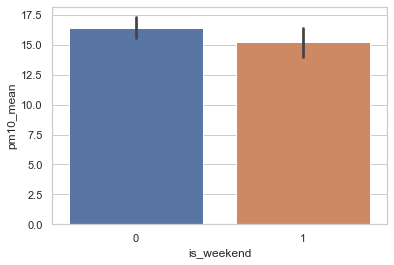

In [11]:
# Plot the is_weekend vs pm10_mean
ax = sns.barplot(x="is_weekend", y="pm10_mean", data=final_df)

## Weather vs Air quality

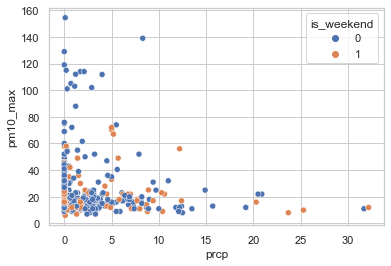

In [12]:
sns.scatterplot(data=final_df, x="prcp", y="pm10_max",hue="is_weekend")
plt.show()

In [13]:
sns.scatterplot(data=final_df, x="tavg", y="pm10_max")
plt.show()

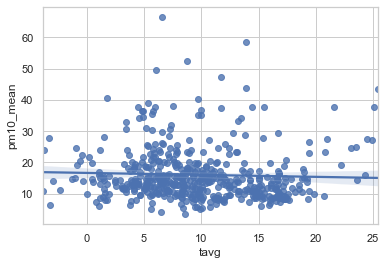

In [16]:
sns.regplot(data=final_df, x="tavg", y="pm10_mean")
plt.show()

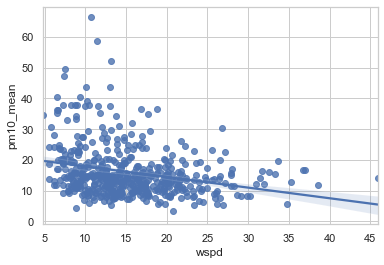

In [17]:
sns.regplot(data=final_df, x="wspd", y="pm10_mean")
plt.show()

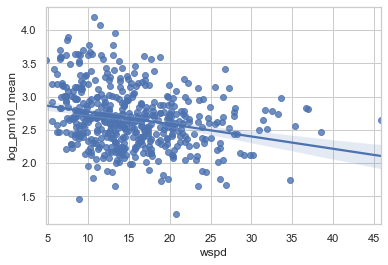

In [18]:
# Plot looks better with log
sns.regplot(data=final_df, x="wspd", y="log_pm10_mean")
plt.show()

# Fitting the model

In [47]:
final_df.columns

Index(['ID', 'Date', 'pm10_mean', 'pm25_mean', 'pm10_max', 'pm25_max',
       'pm10_min', 'pm25_min', 'Unnamed: 0', 'tavg', 'prcp', 'wdir', 'wspd',
       'wpgt', 'pres', 'month', 'day', 'month_string', 'is_weekend',
       'log_pm10_mean'],
      dtype='object')

In [53]:
# Use log_pm10_mean as y
# Try a model: Month, is_weekend, and windspead, avg_

# Create X-matrix (Design matrix) and y the response variable
X = final_df[['is_weekend','wspd','month_string','tavg','wpgt','prcp']]
#X = final_df[['is_weekend','wspd','tavg']]
Y = final_df['log_pm10_mean']
 
# Create dummy variable for categorical columns
X = pd.get_dummies(data=X, drop_first=True)
X.head(100)
#Y.head(100)

is_weekend  wspd  tavg  wpgt  prcp  month_string_August  \
0             0   6.6   4.8  20.4   0.0                    0   
1             0  16.1   7.3  37.0   0.0                    0   
2             0  17.3   7.0  35.2   1.5                    0   
3             1  12.8   4.5  29.6   0.0                    0   
4             1  11.1   5.5  25.9   0.0                    0   
..          ...   ...   ...   ...   ...                  ...   
96            0  12.7  12.5  31.5   0.9                    0   
97            0   8.6  11.0  24.1   0.0                    0   
98            0   8.8  13.5  20.4   0.0                    0   
99            0  11.4  13.9  29.6   0.0                    0   
100           0  13.0  13.9  29.6   0.0                    0   

     month_string_December  month_string_February  month_string_January  \
0                        0                      0                     1   
1                        0                      0                     1   
2                        0                      0                     1   
3                        0                      0                     1   
4                        0                      0                     1   
..                     ...                    ...                   ...   
96                       0                      0                     0   
97                       0                      0                     0   
98                       0                      0                     0   
99                       0                      0                     0   
100                      0                      0                     0   

     month_string_July  month_string_June  month_string_Mai  \
0                    0                  0                 0   
1                    0                  0                 0   
2                    0                  0                 0   
3                    0                  0                 0   
4                    0                  0                 0   
..                 ...                ...               ...   
96                   0                  0                 0   
97                   0                  0                 0   
98                   0                  0                 0   
99                   0                  0                 0   
100                  0                  0                 0   

     month_string_March  month_string_November  month_string_October  \
0                     0                      0                     0   
1                     0                      0                     0   
2                     0                      0                     0   
3                     0                      0                     0   
4                     0                      0                     0   
..                  ...                    ...                   ...   
96                    0                      0                     0   
97                    0                      0                     0   
98                    0                      0                     0   
99                    0                      0                     0   
100                   0                      0                     0   

     month_string_September  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
..                      ...  
96                        0  
97                        0  
98                        0  
99                        0  
100                       0  

[100 rows x 16 columns]

In [80]:
# Fit the model

model = LinearRegression()
model.fit(X,Y)

LinearRegression()

In [81]:
# Intercept and coefficients
print(model.intercept_)
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

3.022087739844352


Coefficient
is_weekend                -0.025836
wspd                      -0.020933
tavg                       0.028128
month_string_August       -0.575439
month_string_December     -0.318377
month_string_February     -0.111406
month_string_January      -0.200975
month_string_July         -0.953673
month_string_June         -0.602424
month_string_Mai          -0.312728
month_string_March         0.016695
month_string_November      0.048301
month_string_October      -0.597093
month_string_September    -0.700695

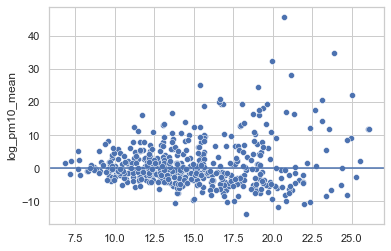

In [82]:
# Not a constant variance, hard to pick up the largest values

# Predict and calculate residuals
predictions = model.predict(X)
predictions_exp = np.exp(predictions)
residuals = np.exp(Y) - predictions_exp

# Plot the fitted vs residual plot
ax = sns.scatterplot(x= predictions_exp,y = residuals)
# Add a horizontal line
ax.axhline(0)
plt.show()

 # Classifier

In [54]:
# https://www.metoffice.gov.uk/weather/guides/air-quality
# pm over 35?



# Create a classifier column based on the mean of 2.5 or 10
# Can use pm10 or 2.5
def is_pollution (row):
    if row['pm10_mean'] > 50 or row['pm25_mean'] > 25:
        return 1
    return 0

final_df['is_pollution'] = final_df.apply (lambda row: is_pollution(row), axis=1)









In [58]:
# Create the logistic regression model
# Create X-matrix (Design matrix) and y the response variable
X = final_df[['is_weekend','wpgt','month_string','tavg']]
#X = final_df[['is_weekend','wspd','tavg']]
Y = final_df['is_pollution']
 
# Create dummy variable for categorical columns
X = pd.get_dummies(data=X, drop_first=True)


clf = LogisticRegression(random_state=0).fit(X, Y)



In [59]:
print(clf.intercept_)
print(clf.coef_)
print(X.columns)
#coeff_parameter = pd.DataFrame(clf.coef_,X.columns,columns=['Coefficient'])

[1.51181359]
[[-0.08438585 -0.20870285  0.09033133  0.4398375  -0.44597368 -0.50738242
   0.34940398 -0.67985016 -0.72053098 -0.90178892  0.94940885  1.35676428
  -0.45536563 -0.76550904]]
Index(['is_weekend', 'wpgt', 'tavg', 'month_string_August',
       'month_string_December', 'month_string_February',
       'month_string_January', 'month_string_July', 'month_string_June',
       'month_string_Mai', 'month_string_March', 'month_string_November',
       'month_string_October', 'month_string_September'],
      dtype='object')


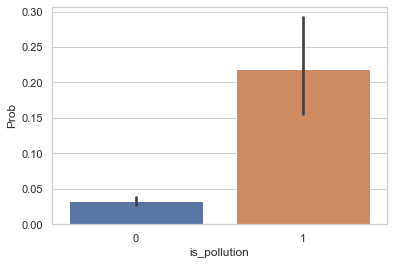

In [63]:
# Here we can see that the model is not predicting high probabilites


final_df['Prob'] = clf.predict_proba(X)[:,1]


# Predictions
ax = sns.barplot(x="is_pollution", y="Prob",data = final_df)

In [62]:
from sklearn import metrics
y = final_df['is_pollution']
pred = final_df['Prob']
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
metrics.auc(fpr, tpr)

/opt/anaconda3/envs/pp-proj2/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


nan